In [1]:
# Librerias
import talib
import numpy as np
import pandas as pd

# Enviroment
import os
from dotenv import load_dotenv

# Librerías de stock
from finta import TA
import yfinance as yf
import mplfinance as mpf
from pandas_datareader import data as pdr
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData


# Librería de graficos
import plotly.express as px

# Análisis de cartera
Esta sección tendrá los siguientes pasos:
- Conectarse a IB
- Extraer las empresas o ETFS en los que estoy invertido
- Análisis de cartera (iré desarrollando el análisis con forme vaya avanzando)

In [86]:
# Importamos librerias
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import Order
from ibapi.utils import iswrapper
import threading
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
from ib_async import *
util.startLoop()  # uncomment this line when in a notebook

ib = IB()
ib.connect('127.0.0.1', 4001, clientId=9)

<IB connected to 127.0.0.1:4001 clientId=9>

In [50]:
# Obtenemos el id de la cuenta
ib.managedAccounts()

['U10244034']

In [52]:
posiciones = ib.positions(account='U10244034')

In [57]:
pos_df = pd.DataFrame(posiciones)

In [69]:
# Funcion para extraer la información de la columna contract
def extract_option_info(option_obj):
    return {
        'conId': option_obj.conId,
        'symbol': option_obj.symbol,
        'lastTradeDateOrContractMonth': option_obj.lastTradeDateOrContractMonth,
        'strike': option_obj.strike,
        'right': option_obj.right,
        'multiplier': option_obj.multiplier,
        'currency': option_obj.currency,
        'localSymbol': option_obj.localSymbol,
        'tradingClass': option_obj.tradingClass
    }

In [ ]:
# Obtenemos un data frame a partir de la columna de contract
contracts_expand = pd.json_normalize(
    pos_df.loc[:,"contract"].apply(lambda x : extract_option_info(x))
    )

In [77]:
# Concatenamos ambos dfs
df_final = pd.concat([pos_df, contracts_expand], axis=1)

In [79]:
# Analizamos el peso de cada inversion
total_invertido = df_final.loc[:,"avgCost"].sum()

# Calcular el peso de cada inversión en la cartera
df_final['peso'] = (df_final['avgCost'] / total_invertido) * 100

In [110]:
df_final['right'] = np.where(df_final['right'] == 'C', 'call', np.where(df_final['right'] == '', 'stock', df_final['right']))

In [97]:
# Ordenamos el df
df_final = df_final.sort_values('peso', ascending=False)

In [111]:
df_final

,account,contract,position,avgCost,conId,symbol,lastTradeDateOrContractMonth,strike,right,multiplier,currency,localSymbol,tradingClass,peso
9,U10244034,"Option(conId=732346004, symbol='META', lastTra...",1.0,621.04400,732346004,META,20260116,1150.0,call,100,USD,META 260116C01150000,META,20.640504
12,U10244034,"Option(conId=735906609, symbol='ETHU', lastTra...",1.0,376.89400,735906609,ETHU,20250620,10.0,call,100,USD,ETHU 250620C00010000,ETHU,12.526137
0,U10244034,"Option(conId=715390451, symbol='AMZN', lastTra...",2.0,375.83795,715390451,AMZN,20260116,300.0,call,100,USD,AMZN 260116C00300000,AMZN,12.491039
1,U10244034,"Option(conId=668109697, symbol='XRT', lastTrad...",1.0,350.04400,668109697,XRT,20260116,95.0,call,100,USD,XRT 260116C00095000,XRT,11.633773
3,U10244034,"Option(conId=732345584, symbol='META', lastTra...",2.0,267.69645,732345584,META,20250919,1150.0,call,100,USD,META 250919C01150000,META,8.896938
4,U10244034,"Option(conId=683281377, symbol='RUM', lastTrad...",1.0,250.29400,683281377,RUM,20260116,15.0,call,100,USD,RUM 260116C00015000,RUM,8.318564
2,U10244034,"Option(conId=636070910, symbol='IWM', lastTrad...",1.0,182.05300,636070910,IWM,20250620,280.0,call,100,USD,IWM 250620C00280000,IWM,6.050563
7,U10244034,"Option(conId=653094759, symbol='BITO', lastTra...",1.0,175.80300,653094759,BITO,20260116,25.0,call,100,USD,BITO 260116C00025000,BITO,5.842843
5,U10244034,"Option(conId=714846852, symbol='SOXL', lastTra...",1.0,158.51160,714846852,SOXL,20260116,95.0,call,100,USD,SOXL 260116C00095000,SOXL,5.268160
8,U10244034,"Option(conId=653276028, symbol='XLE', lastTrad...",1.0,132.79400,653276028,XLE,20260116,120.0,call,100,USD,XLE 260116C00120000,XLE,4.413431


/var/folders/1f/bsxjdbg56jlfz517g824xrh80000gn/T/ipykernel_3369/1352582098.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='symbol', y='peso', data=df_final, palette='viridis', legend=False)


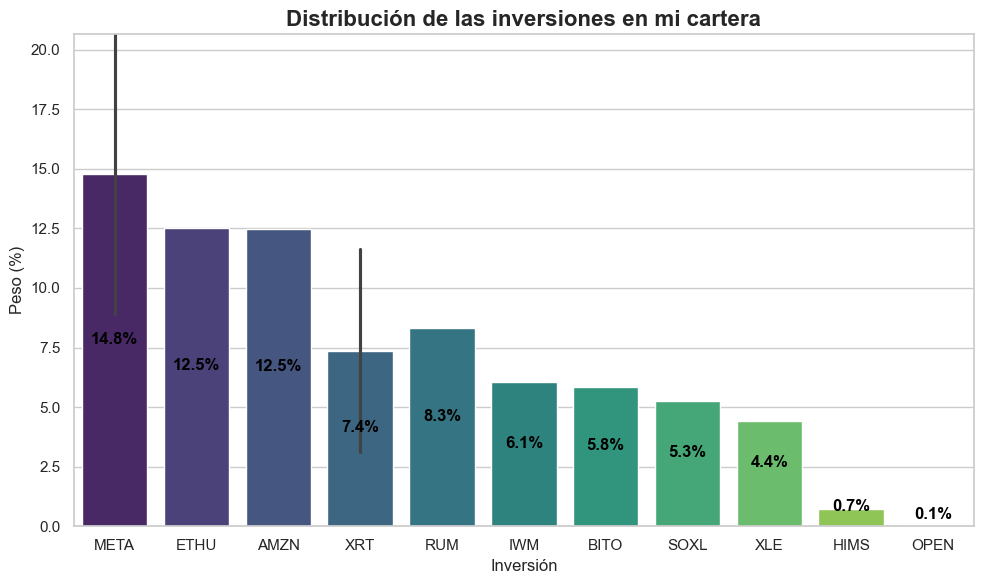

In [116]:
# Configurar estilo de Seaborn
sns.set(style="whitegrid")  # Establecer el estilo de fondo blanco con grid

# Crear gráfico de barras con Seaborn
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='symbol', y='peso', data=df_final, palette='viridis', legend=False)

# Personalizar el gráfico
bar_plot.set_title('Distribución de las inversiones en mi cartera', fontsize=16, weight='bold')
bar_plot.set_xlabel('Inversión', fontsize=12)
bar_plot.set_ylabel('Peso (%)', fontsize=12)
bar_plot.set_ylim(0, df_final.loc[:,"peso"].max())  # Asegurarse que el eje Y vaya de 0 a 100%

# Añadir etiquetas con los porcentajes sobre las barras
for p in bar_plot.patches:
    height = p.get_height()
    # Añadir el porcentaje encima de cada barra
    bar_plot.annotate(f'{height:.1f}%', 
                      (p.get_x() + p.get_width() / 2., height / 2), 
                      ha='center', va='center', 
                      fontsize=12, color='black', fontweight='bold', 
                      xytext=(0, 8), textcoords='offset points')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

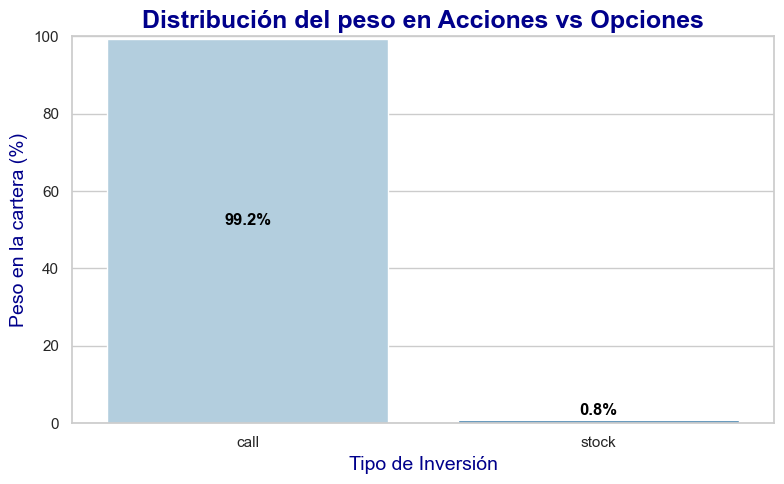

In [115]:
# Agrupar por right de inversión y sumar los pesos
df_grouped = df_final.groupby('right').agg({'peso': 'sum'}).reset_index()

# Configurar el estilo de Seaborn para un aspecto limpio
sns.set(style="whitegrid")  # Fondo blanco con líneas de cuadrícula

# Crear gráfico de barras con Seaborn
plt.figure(figsize=(8, 5))

# Usar una paleta de colores atractiva
bar_plot = sns.barplot(x='right', y='peso', data=df_grouped, palette='Blues', hue='right')

# Personalizar el gráfico
bar_plot.set_title('Distribución del peso en Acciones vs Opciones', fontsize=18, weight='bold', color='darkblue')
bar_plot.set_xlabel('Tipo de Inversión', fontsize=14, color='darkblue')
bar_plot.set_ylabel('Peso en la cartera (%)', fontsize=14, color='darkblue')
bar_plot.set_ylim(0, 100)  # Asegurarse de que el eje Y vaya de 0 a 100%

# Añadir etiquetas con los porcentajes sobre las barras
for p in bar_plot.patches:
    height = p.get_height()
    # Añadir el porcentaje encima de cada barra
    bar_plot.annotate(f'{height:.1f}%', 
                      (p.get_x() + p.get_width() / 2., height / 2), 
                      ha='center', va='center', 
                      fontsize=12, color='black', fontweight='bold', 
                      xytext=(0, 8), textcoords='offset points')

# Mejorar el espaciado del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Analizamos rentabilidad

In [124]:
def obtener_precio_activo(symbol, strike=None, vencimiento=None, tipo='stock'):
    # Si es una acción
    if tipo == 'stock':
        ticker = yf.Ticker(symbol)
        precio_actual = ticker.history(period="1d")['Close'].iloc[-1]
        return precio_actual
    # Si es una opción (tipo = 'call' o 'put')
    elif tipo in ['call', 'put']:
        ticker = yf.Ticker(symbol)
        
        # Verificamos si el vencimiento es correcto
        if vencimiento not in ticker.options:
            print(f"No hay opciones con vencimiento {vencimiento} para {symbol}")
            return None
        
        # Obtenemos las opciones para la fecha de vencimiento
        opciones_vencimiento = ticker.option_chain(vencimiento)
        
        # Seleccionamos las opciones de tipo 'call' o 'put'
        if tipo == 'call':
            opciones_datos = opciones_vencimiento.calls
        elif tipo == 'put':
            opciones_datos = opciones_vencimiento.puts
        
        # Buscamos la opción con el strike correspondiente
        opcion = opciones_datos[opciones_datos['strike'] == strike]
        
        if opcion.empty:
            print(f"No se encontró opción con strike {strike} para {symbol}")
            return None
        else:
            # Devolvemos el precio de la opción
            return opcion['lastPrice'].iloc[0]
    else:
        print("Tipo de activo desconocido")
        return None

In [128]:
# Crear una nueva columna en el DataFrame para el precio actual
df_final['precio_actual'] = df_final['symbol'].apply(
    lambda row : obtener_precio_activo(symbol=row["symbol"] , strike=row["strike"] , vencimiento=int(row["lastTradeDateOrContractMonth"]), tipo=row["right"]))

TypeError: string indices must be integers, not 'str'

In [127]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 9 to 10
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   account                       13 non-null     object 
 1   contract                      13 non-null     object 
 2   position                      13 non-null     float64
 3   avgCost                       13 non-null     float64
 4   conId                         13 non-null     int64  
 5   symbol                        13 non-null     object 
 6   lastTradeDateOrContractMonth  13 non-null     object 
 7   strike                        13 non-null     float64
 8   right                         13 non-null     object 
 9   multiplier                    13 non-null     object 
 10  currency                      13 non-null     object 
 11  localSymbol                   13 non-null     object 
 12  tradingClass                  13 non-null     object 
 13  peso        

In [121]:
# Calcular la rentabilidad para cada acción
df_final["precio_compra"] = df_final.loc[:,"avgCost"] / df_final.loc[:,"position"]
df_final['rentabilidad'] = ((df_final['precio_actual'] - df_final['precio_compra']) / df_final['precio_compra']) * 100

# Calcular el valor total invertido y la rentabilidad total (si te interesa)
df_final['valor_actual'] = df_final['precio_actual'] * df_final['position']
df_final['rentabilidad_total'] = ((df_final['valor_actual'] - df_final['avgCost']) / df_final['avgCost']) * 100

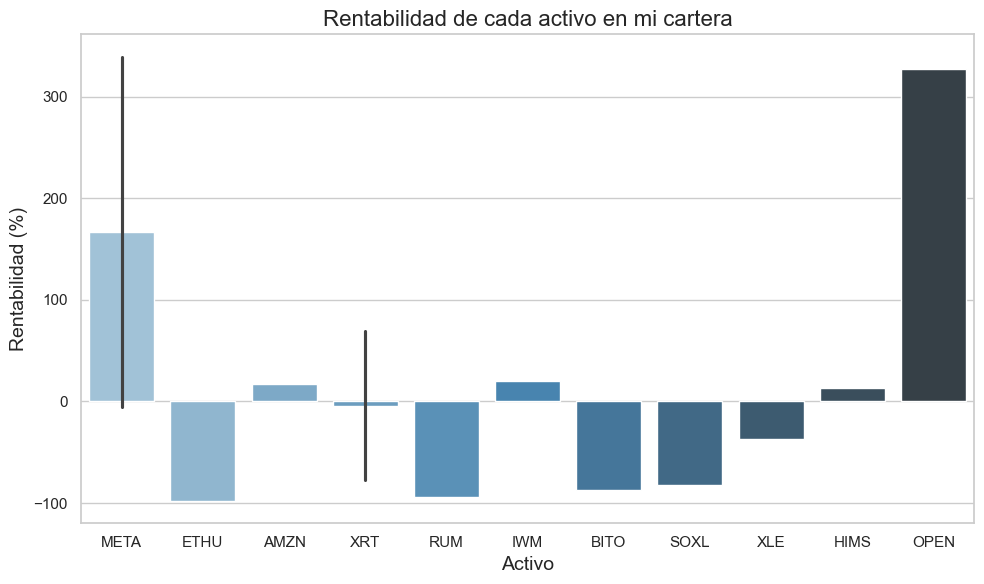

In [123]:
# Pintamos la info
# Crear un gráfico de barras de rentabilidad
plt.figure(figsize=(10, 6))
sns.barplot(x='symbol', y='rentabilidad', data=df_final, palette='Blues_d', hue='symbol')

# Añadir título y etiquetas
plt.title('Rentabilidad de cada activo en mi cartera', fontsize=16)
plt.xlabel('Activo', fontsize=14)
plt.ylabel('Rentabilidad (%)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


# Predicciones usando Ollama
En esta sección realizamos una serie de análisis técnicos usando ollama en local

In [12]:
# Librerias

# Data Importing Libraries
import yfinance as yf
from finvizfinance.quote import finvizfinance

# Data Modeling Library
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Charts
import plotly.graph_objects as go

# Data Manipulation
import pandas as pd
import numpy as np

# Avoid Forecasting on Holidays
import holidays

# Create Local LLM Server Connection
# from langchain_community.llms import Ollama
from langchain_ollama import OllamaLLM

# Interactive Web App UI
import streamlit as st

In [13]:
# Connect to local Ollama server
llm = OllamaLLM(model='llama3')

In [51]:
# Function to classify sentiment
def classify_sentiment(title):
    output = llm.invoke(f"Classify the sentiment as 'POSITIVE' or 'NEGATIVE' or 'NEUTRAL' with just that one word only, no additional words or reasoning: {title}")
    return output.strip()  # Ensure the response is clean and without extra spaces

# Function to get and process news data
def get_news_data(ticker):

    # Data Pull
    stock = finvizfinance(ticker) 
    news_df = stock.ticker_news()

    # Preprocess before putting into LLM
    news_df['Title'] = news_df['Title'].str.lower()

    # Classify Sentiment function applied to each row of news_df
    news_df['sentiment'] = news_df['Title'].apply(classify_sentiment)

    # Postprocess after putting into LLM
    news_df['sentiment'] = news_df['sentiment'].str.upper()
    news_df = news_df[news_df['sentiment'] != 'NEUTRAL']
    news_df['Date'] = pd.to_datetime(news_df['Date'])
    news_df['DateOnly'] = news_df['Date'].dt.date

    return news_df

# Function to group and process sentiment data
def process_sentiment_data(news_df):

    # Reshape data to have df with columns: Date, # of positive Articles, # of negative Articles
    grouped = news_df.groupby(['DateOnly', 'sentiment']).size().unstack(fill_value=0)
    grouped = grouped.reindex(columns=['POSITIVE', 'NEGATIVE'], fill_value=0)

    # Create rolling averages that count number of positive and negative sentiment articles within past t days
    grouped['7day_avg_positive'] = grouped['POSITIVE'].rolling(window=7, min_periods=1).sum()
    grouped['7day_avg_negative'] = grouped['NEGATIVE'].rolling(window=7, min_periods=1).sum()

    # Create "Percent Positive" by creating percentage measure
    grouped['7day_pct_positive'] = grouped['POSITIVE'] / (grouped['POSITIVE'] + grouped['NEGATIVE'])
    result_df = grouped.reset_index()

    return result_df

# Function to fetch and process stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date) # Pull ticker data
    # Eliminamos las columnas multiindex que vienen ahora los df de yfinance
    stock_data.columns = stock_data.columns.get_level_values(0)
    stock_data['Pct_Change'] = stock_data['Close'].pct_change() * 100 # Transform closing value to percent change in closing value since previous day
    return stock_data

# Function to combine sentiment and stock data
def combine_data(result_df, stock_data):
    combined_df = result_df.set_index('DateOnly').join(stock_data[['Pct_Change']], how='inner')
    combined_df['lagged_7day_pct_positive'] = combined_df['7day_pct_positive'].shift(1) # Lag sentiment feature by 1 day for temporal alignment
    return combined_df

# Function to calculate Pearson correlation
def calculate_correlation(combined_df):
    correlation_pct_change = combined_df[['lagged_7day_pct_positive', 'Pct_Change']].corr().iloc[0, 1]
    return correlation_pct_change

# Function to get future dates excluding weekends and holidays
def get_future_dates(start_date, num_days):
    us_holidays = holidays.US()
    future_dates = []
    current_date = start_date
    while len(future_dates) < num_days:
        if current_date.weekday() < 5 and current_date not in us_holidays:
            future_dates.append(current_date)
        current_date += pd.Timedelta(days=1)
    return future_dates

# Function to fit ARIMAX model and forecast
def fit_and_forecast(combined_df, forecast_steps=3):
    endog = combined_df['Pct_Change'].dropna()  # Dependent variable
    exog = combined_df['lagged_7day_pct_positive'].dropna()  # Predictor variable
    endog = endog.loc[exog.index]  # Align variables
    model = SARIMAX(endog, exog=exog, order=(1, 1, 1))  # ARIMAX model
    fit = model.fit(disp=False)  # Fit model
    
    future_dates = get_future_dates(combined_df.index[-1], forecast_steps)  # Future dates
    future_exog = combined_df['lagged_7day_pct_positive'][-forecast_steps:].values.reshape(-1, 1)  # Future exogenous values
    
    forecast = fit.get_forecast(steps=forecast_steps, exog=future_exog)  # Get forecast
    forecast_mean = forecast.predicted_mean  # Predicted mean
    forecast_ci = forecast.conf_int()  # Confidence intervals
    
    return forecast_mean, forecast_ci, future_dates  # Return results


# Function to create and display plot
def create_plot(combined_df, forecast_mean, forecast_ci, forecast_index):
    # Standardize the sentiment proportion
    sentiment_std = (combined_df['7day_pct_positive'] - combined_df['7day_pct_positive'].mean()) / combined_df['7day_pct_positive'].std()

    fig = go.Figure()
    
    # Add standardized sentiment proportion
    fig.add_trace(go.Scatter(
        x=combined_df.index, 
        y=sentiment_std, 
        name='Standardized Sentiment Proportion', 
        line=dict(color='blue'), 
        mode='lines'
    ))
    
    # Add stock percentage change
    fig.add_trace(go.Scatter(
        x=combined_df.index, 
        y=combined_df['Pct_Change'], 
        name='Stock Pct Change', 
        line=dict(color='green'), 
        yaxis='y2', 
        mode='lines'
    ))
    
    # Add forecasted stock percentage change
    fig.add_trace(go.Scatter(
        x=forecast_index, 
        y=forecast_mean, 
        name='Forecasted Pct Change', 
        line=dict(color='red'), 
        mode='lines'
    ))
    
    # Add confidence intervals for the forecast
    fig.add_trace(go.Scatter(
        x=np.concatenate([forecast_index, forecast_index[::-1]]),
        y=np.concatenate([forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1][::-1]]),
        fill='toself',
        fillcolor='rgba(255,0,0,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ))
    
    # Update layout with appropriate y-axis ranges
    fig.update_layout(
        title='Sentiment Proportion and Stock Percentage Change with Forecast',
        xaxis_title='Date',
        yaxis=dict(
            title='Standardized Sentiment Proportion',
            titlefont=dict(color='blue')
        ),
        yaxis2=dict(
            title='Stock Pct Change',
            titlefont=dict(color='green'),
            overlaying='y',
            side='right'
        ),
        template='plotly_dark'
    )
    fig.show()
    # st.plotly_chart(fig)

In [30]:
# 1 Obtenemos la data
news_df = get_news_data(ticker="AAPL")
# 2 Llamamos al modelo descargado para que nos clasifique los resultados
result_df = process_sentiment_data(news_df=news_df)
# 3 Sacamos el start date y el end date del df
start_date = result_df.loc[:,"DateOnly"].min().strftime('%Y-%m-%d')
end_date = result_df.loc[:,"DateOnly"].max().strftime('%Y-%m-%d')


/var/folders/1f/bsxjdbg56jlfz517g824xrh80000gn/T/ipykernel_2857/962858264.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['Date'] = pd.to_datetime(news_df['Date'])
/var/folders/1f/bsxjdbg56jlfz517g824xrh80000gn/T/ipykernel_2857/962858264.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['DateOnly'] = news_df['Date'].dt.date


In [47]:
# 4 stock data
stock_data = get_stock_data(ticker='AAPL', start_date=start_date, end_date=end_date)

[*********************100%***********************]  1 of 1 completed


In [50]:
# 5 Combinamos el df
combined_df = combine_data(result_df=result_df, stock_data=stock_data)
# 6 Calculamos correlation
correlation_pct_change = calculate_correlation(combined_df=combined_df)

# Printeamos la correlacion
print(f'La correlación de earson entre lagged sentiment score y el cambio porcentual es --> {correlation_pct_change}')
forecast_mean, forecast_ci, forecast_index = fit_and_forecast(combined_df=combined_df)

La correlación de earson entre lagged sentiment score y el cambio porcentual es --> 0.1886350636867532


/Users/nestoralaminospelegrina/.pyenv/versions/3.13.1/envs/stock-app/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

/Users/nestoralaminospelegrina/.pyenv/versions/3.13.1/envs/stock-app/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

/Users/nestoralaminospelegrina/.pyenv/versions/3.13.1/envs/stock-app/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.



In [52]:
# Creamos el grafico
create_plot(combined_df=combined_df, forecast_mean=forecast_mean, forecast_ci=forecast_ci, forecast_index=forecast_index)

# Análisis técnico

In [12]:
# Descargamos los datos de apple mismo
start_date = "2024-01-01"
end_date = "2024-12-12"

df = yf.download("AAPL", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [20]:
rename_columns = {'Open' : 'open', 
                  'High':  'high', 
                  'Low' : 'low', 
                  'Close' : 'close', 
                  'Adj Close' : 'adj close', 
                  'Volume' : 'volume'}
df.rename(columns=rename_columns, inplace=True)
df.columns = df.columns.droplevel('Ticker')

In [15]:
# Aseguramos que el índice sea datetime
df.index = pd.DatetimeIndex(df.index)

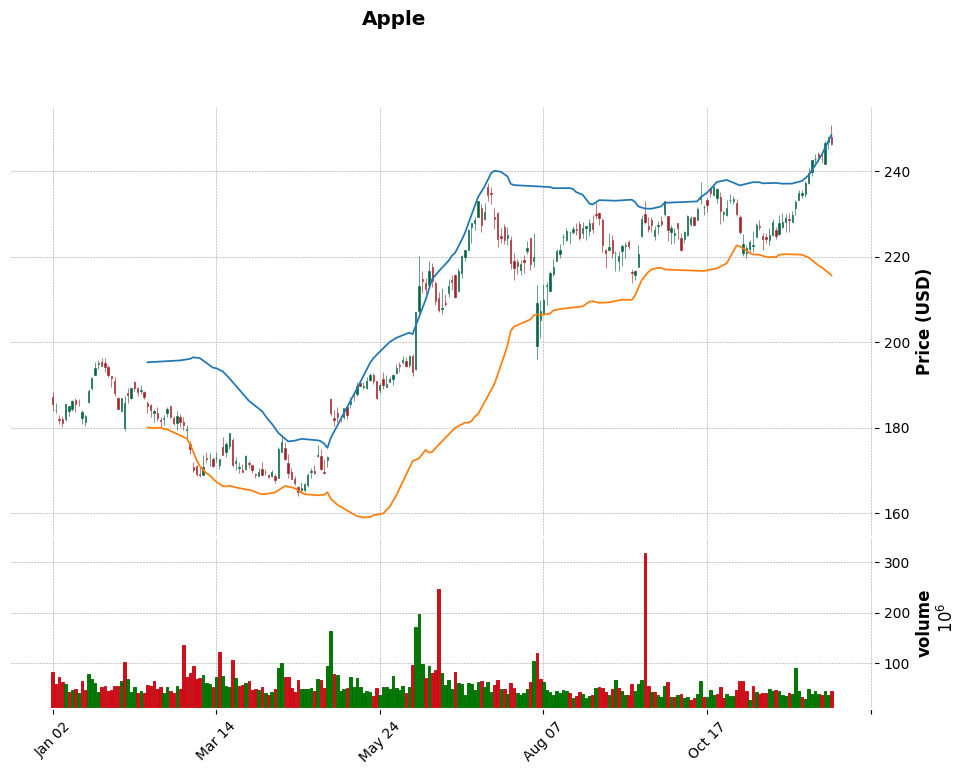

In [23]:
# Bandas de bolinger
bbands = TA.BBANDS(df, 30)


bands_plot = pd.concat([bbands.BB_UPPER, bbands.BB_LOWER], axis=1)

apd = mpf.make_addplot(bands_plot)

mpf.plot(
    df,
    type='candle',
    style='charles',
    title='Apple',
    ylabel='Price (USD)',
    ylabel_lower='volume',
    volume=True,
    figscale=1.5,
    addplot=apd
)


# Leemos datos con alpha vantage

In [2]:
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Obtener la clave de la API
api_key = os.getenv('API_KEY')

if api_key:
    print(f"Clave de API leida")
else:
    print("Error: No se encontró la clave API.")

Clave de API leida


In [14]:
# Cargamos la data
ts = TimeSeries(key=api_key, output_format="pandas")
data, metadata = ts.get_monthly_adjusted(symbol="ENPH")

In [15]:
data.sort_index()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount
date,,,,,,,
2012-04-30,7.65,8.2000,6.62,7.28,7.28,2458400.0,0.0
2012-05-31,7.50,9.5700,6.85,6.90,6.90,1853400.0,0.0
2012-06-29,7.43,7.9199,4.90,6.22,6.22,3472400.0,0.0
2012-07-31,6.22,6.6000,5.40,5.81,5.81,1690000.0,0.0
2012-08-31,5.87,6.8900,4.66,4.96,4.96,2585100.0,0.0
...,...,...,...,...,...,...,...
2024-05-31,109.05,134.0000,102.34,127.90,127.90,88718966.0,0.0
2024-06-28,131.21,141.6300,98.37,99.71,99.71,73553918.0,0.0
2024-07-31,99.50,122.9500,95.21,115.11,115.11,100529131.0,0.0


In [2]:
df = yf.download("MSFT", start="2024-09-01", end="2024-09-07")

[*********************100%***********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-03,417.910004,419.880005,407.029999,409.440002,409.440002,20313600
2024-09-04,405.910004,411.239990,404.369995,408.899994,408.899994,15135800
2024-09-05,407.619995,413.100006,406.130005,408.390015,408.390015,14195500
2024-09-06,409.059998,410.649994,400.799988,401.700012,401.700012,19382200


# Análisis fundamental

In [3]:
# Descargamos los datos
fd = FundamentalData(api_key, output_format="pandas")
income_statement = fd.get_income_statement_annual("OPEN")[0]

In [4]:
is1 = income_statement.T[2:]
is1.columns = list(income_statement.T.iloc[0])

In [7]:
is1

,2023-12-31,2022-12-31,2021-12-31,2020-12-31
grossProfit,487000000,667000000,730000000,220000000
totalRevenue,6946000000,15567000000,8021000000,2583000000
costOfRevenue,6459000000,14900000000,7291000000,2363000000
costofGoodsAndServicesSold,65000000,737000000,56000000,7596000
operatingIncome,-386000000,-931000000,-568000000,-186000000
sellingGeneralAndAdministrative,692000000,1352000000,1164000000,347490000
researchAndDevelopment,167000000,169000000,134000000,56000000
operatingExpenses,873000000,1598000000,1298000000,406000000
investmentIncomeNet,None,None,None,None
netInterestIncome,-211000000,-385000000,-143000000,-67806000


In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Definir un mapa de colores personalizado
def reverse_cmap(cmap_name):
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(np.arange(cmap.N))
    colors = colors[::-1]  # Invertir el orden de los colores
    return mcolors.LinearSegmentedColormap.from_list(f"reversed_{cmap_name}", colors)

In [13]:
# Definir un mapa de colores para las filas basado en una escala
def row_gradient(row):
    # Normalizar los valores de la fila para usar en el gradiente de colores
    norm = plt.Normalize(vmin=row.min(), vmax=row.max())
    cmap = plt.get_cmap(reverse_cmap('RdYlGn'))  # Escoge el mapa de colores que prefieras
    colors = [mcolors.to_hex(cmap(norm(val))) for val in row]
    return [f'background-color: {color}' for color in colors]

# Convertir las columnas a tipo float, manejando valores 'None' y errores
df = is1.apply(pd.to_numeric, errors='coerce')

# Aplicar el gradiente de color por fila
styled_df = df.style.apply(row_gradient, axis=1)
styled_df

,2023-12-31,2022-12-31,2021-12-31,2020-12-31
grossProfit,487000000.000000,667000000.000000,730000000.000000,220000000.000000
totalRevenue,6946000000.000000,15567000000.000000,8021000000.000000,2583000000.000000
costOfRevenue,6459000000.000000,14900000000.000000,7291000000.000000,2363000000.000000
costofGoodsAndServicesSold,65000000.000000,737000000.000000,56000000.000000,7596000.000000
operatingIncome,-386000000.000000,-931000000.000000,-568000000.000000,-186000000.000000
sellingGeneralAndAdministrative,692000000.000000,1352000000.000000,1164000000.000000,347490000.000000
researchAndDevelopment,167000000.000000,169000000.000000,134000000.000000,56000000.000000
operatingExpenses,873000000.000000,1598000000.000000,1298000000.000000,406000000.000000
investmentIncomeNet,nan,nan,nan,nan
netInterestIncome,-211000000.000000,-385000000.000000,-143000000.000000,-67806000.000000


In [28]:


# Convertir las columnas a tipo float, manejando valores 'None' y errores
df = df.apply(pd.to_numeric, errors='coerce')

# Rellenar valores NaN con 0 (o el valor que prefieras)
df_filled = df.fillna(0)

# Crear un mapa de colores personalizado
custom_cmap = reverse_cmap('coolwarm')

# Aplicar el gradiente de colores con el mapa de colores personalizado
styled_df = df_filled.style.background_gradient(cmap=custom_cmap)

# Aplicar un gradiente de colores
styled_df = df_filled.style.background_gradient(cmap='coolwarm')

# Mostrar el DataFrame estilizado en Jupyter Notebook (o en un entorno similar)
styled_df

,2023-12-31,2022-12-31,2021-12-31,2020-12-31
grossProfit,487000000.000000,667000000.000000,730000000.000000,220000000.000000
totalRevenue,6946000000.000000,15567000000.000000,8021000000.000000,2583000000.000000
costOfRevenue,6459000000.000000,14900000000.000000,7291000000.000000,2363000000.000000
costofGoodsAndServicesSold,65000000.000000,737000000.000000,56000000.000000,7596000.000000
operatingIncome,-386000000.000000,-931000000.000000,-568000000.000000,-186000000.000000
sellingGeneralAndAdministrative,692000000.000000,1352000000.000000,1164000000.000000,347490000.000000
researchAndDevelopment,167000000.000000,169000000.000000,134000000.000000,56000000.000000
operatingExpenses,873000000.000000,1598000000.000000,1298000000.000000,406000000.000000
investmentIncomeNet,0.000000,0.000000,0.000000,0.000000
netInterestIncome,-211000000.000000,-385000000.000000,-143000000.000000,-67806000.000000


In [18]:
# Crear el DataFrame
df = pd.DataFrame(is1, index=[
    'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold',
    'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment',
    'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome',
    'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation',
    'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense',
    'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome'
])

